# Grid-based analysis of based on PCA and UMAP

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from libpysal.graph import Graph
from esda import Moran_Local, Geary_Local
from sklearn.decomposition import PCA
from umap import UMAP

Load all buildings represented as points.

In [2]:
complete = gpd.read_parquet("/data/uscuni-boundaries/classification/v202511/").reset_index(drop=True)

In [3]:
complete

,geometry,level_7_label,area
0,POINT (4292815.658 3392096.245),36,124.350225
1,POINT (4292819.583 3392091.712),36,1.402272
2,POINT (4292810.814 3392094.661),36,14.988636
3,POINT (4292809.522 3392043.982),36,23.192214
4,POINT (4294130.039 3392097.282),57,65.245111
...,...,...,...
159599314,POINT (4128415.517 2896813.41),26,55.429514
159599315,POINT (4128415.095 2896819.459),26,59.189652
159599316,POINT (4128396.856 2896812.442),26,34.162277
159599317,POINT (4128396.626 2896802.56),26,16.241510


Map ids to level 3.

In [4]:
final_clusters = pd.read_parquet(
    "/data/uscuni-ulce/processed_data/clusters/cluster_mapping_v10.pq"
)
complete["level_3"] = complete.level_7_label.map(final_clusters[3])
complete

,geometry,level_7_label,area,level_3
0,POINT (4292815.658 3392096.245),36,124.350225,4
1,POINT (4292819.583 3392091.712),36,1.402272,4
2,POINT (4292810.814 3392094.661),36,14.988636,4
3,POINT (4292809.522 3392043.982),36,23.192214,4
4,POINT (4294130.039 3392097.282),57,65.245111,5
...,...,...,...,...
159599314,POINT (4128415.517 2896813.41),26,55.429514,3
159599315,POINT (4128415.095 2896819.459),26,59.189652,3
159599316,POINT (4128396.856 2896812.442),26,34.162277,3
159599317,POINT (4128396.626 2896802.56),26,16.241510,3


Make a grid

In [5]:
grid_size = 50_000

In [6]:
bds = complete.total_bounds
bds

array([1548185.539145  ,  942249.56623092, 5378847.07173358,
       3799811.41843362])

In [7]:
x = np.arange(bds[0], bds[2], grid_size)
y = np.arange(bds[1], bds[3], grid_size)

In [8]:
xs, ys = np.meshgrid(x, y)

In [9]:
grid = gpd.GeoSeries.from_xy(x=xs.flatten(), y=ys.flatten(), crs=complete.crs).buffer(
    grid_size / 2, cap_style="square"
)

Filter the grid to be only use only cells with a centroid inside the country we cover.

In [10]:
nuts = gpd.read_file(
    "https://gisco-services.ec.europa.eu/distribution/v2/nuts/gpkg/NUTS_RG_01M_2024_3035.gpkg"
)

In [36]:
nuts_l0 = nuts[nuts.CNTR_CODE.isin(["ES", "FR", "BE", "NL", "CZ", "DE", "AT", "PL", "LT", "SK"])].query(
    "LEVL_CODE == 0"
)

nuts_l1 = nuts[nuts.CNTR_CODE.isin(["ES", "FR", "BE", "NL", "CZ", "DE", "AT", "PL", "LT", "SK"])].query(
    "LEVL_CODE == 1"
)

In [127]:
nuts_l0

,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,geometry
1755,ES,0,ES,España,España,NaN,NaN,NaN,"MULTIPOLYGON (((3815056.85 1904971.998, 381575..."
1757,FR,0,FR,France,France,NaN,NaN,NaN,"MULTIPOLYGON (((9980485.23 -3029930.054, 99812..."
1760,DE,0,DE,Deutschland,Deutschland,NaN,NaN,NaN,"MULTIPOLYGON (((4355225.354 2715902.995, 43548..."
1763,AT,0,AT,Österreich,Österreich,NaN,NaN,NaN,"MULTIPOLYGON (((4354847.685 2714710.627, 43552..."
1770,BE,0,BE,Belgique/België,Belgique/België,NaN,NaN,NaN,"MULTIPOLYGON (((3961559.829 3161283.432, 39615..."
1773,CZ,0,CZ,Česko,Česko,NaN,NaN,NaN,"MULTIPOLYGON (((4624842.426 3112217.365, 46255..."
1784,NL,0,NL,Nederland,Nederland,NaN,NaN,NaN,"MULTIPOLYGON (((4105253.514 3377891.917, 41080..."
1785,LT,0,LT,Lietuva,Lietuva,NaN,NaN,NaN,"MULTIPOLYGON (((5233858.233 3797075.982, 52346..."
1792,SK,0,SK,Slovensko,Slovensko,NaN,NaN,NaN,"MULTIPOLYGON (((5003133.924 2988592.038, 50037..."
1795,PL,0,PL,Polska,Polska,NaN,NaN,NaN,"MULTIPOLYGON (((4852825.195 3556096.333, 48551..."


In [15]:
grid.centroid

0        POINT (1548185.539 942249.566)
1        POINT (1598185.539 942249.566)
2        POINT (1648185.539 942249.566)
3        POINT (1698185.539 942249.566)
4        POINT (1748185.539 942249.566)
                     ...               
4461    POINT (5148185.539 3792249.566)
4462    POINT (5198185.539 3792249.566)
4463    POINT (5248185.539 3792249.566)
4464    POINT (5298185.539 3792249.566)
4465    POINT (5348185.539 3792249.566)
Length: 3674, dtype: geometry

In [19]:
grid = grid[grid.centroid.sindex.query(nuts_l0.geometry, output_format='dense', predicate='intersects').any(axis=1)]

Join grid label to points

In [21]:
grid = grid.to_frame("geometry")
joined = complete.sjoin(grid, predicate="within")

Group by grid label and get counts by class.

In [22]:
counts = joined.groupby("index_right").level_7_label.value_counts().unstack().fillna(0)

Normalize

In [23]:
counts = counts.div(counts.sum(axis=1), axis=0)
counts

level_7_label,1,2,3,4,5,6,7,8,9,10,...,101,102,103,104,105,106,107,108,109,110
index_right,,,,,,,,,,,,,,,,,,,,,
5,0.016582,0.012648,0.034463,0.011142,0.019481,0.000000,0.0,0.0,0.015264,0.004875,...,0.017730,0.009336,0.007755,0.020045,0.027630,0.105007,0.022492,0.021777,0.000000,0.033503
7,0.157669,0.000000,0.138650,0.126380,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.113497,0.032515,0.000000,0.000000,0.084663,0.084663,0.000000,0.000000,0.000000,0.000000
8,0.038586,0.000000,0.034529,0.000721,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.021277,0.000000,0.000000,0.000000,0.066534,0.037865,0.010007,0.000000,0.000000,0.033357
9,0.261538,0.000000,0.264957,0.174359,0.000000,0.000000,0.0,0.0,0.123077,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.160684,0.000000,0.000000,0.000000,0.000000,0.000000
82,0.015035,0.003291,0.012895,0.001522,0.001964,0.000000,0.0,0.0,0.005522,0.000968,...,0.029587,0.005964,0.001656,0.005662,0.059671,0.044524,0.037894,0.066526,0.010328,0.013646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4383,0.022221,0.000000,0.005060,0.003462,0.000000,0.003743,0.0,0.0,0.000000,0.000000,...,0.000429,0.000000,0.000000,0.000000,0.000148,0.001065,0.000000,0.000000,0.000000,0.000000
4384,0.024198,0.002738,0.008587,0.020115,0.000036,0.000000,0.0,0.0,0.000000,0.000000,...,0.001537,0.001201,0.002462,0.000793,0.000528,0.000000,0.000468,0.000000,0.000000,0.000000
4385,0.004540,0.000000,0.001395,0.006533,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Join

In [24]:
grid_data = pd.concat([grid, counts], axis=1)

Drop cells outside of the area

In [25]:
grid_data = grid_data.dropna().reset_index()
grid_data

,index,geometry,1,2,3,4,5,6,7,8,...,101,102,103,104,105,106,107,108,109,110
0,5,"POLYGON ((1823185.539 967249.566, 1823185.539 ...",0.016582,0.012648,0.034463,0.011142,0.019481,0.000000,0.0,0.0,...,0.017730,0.009336,0.007755,0.020045,0.027630,0.105007,0.022492,0.021777,0.000000,0.033503
1,7,"POLYGON ((1923185.539 967249.566, 1923185.539 ...",0.157669,0.000000,0.138650,0.126380,0.000000,0.000000,0.0,0.0,...,0.113497,0.032515,0.000000,0.000000,0.084663,0.084663,0.000000,0.000000,0.000000,0.000000
2,8,"POLYGON ((1973185.539 967249.566, 1973185.539 ...",0.038586,0.000000,0.034529,0.000721,0.000000,0.000000,0.0,0.0,...,0.021277,0.000000,0.000000,0.000000,0.066534,0.037865,0.010007,0.000000,0.000000,0.033357
3,9,"POLYGON ((2023185.539 967249.566, 2023185.539 ...",0.261538,0.000000,0.264957,0.174359,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.160684,0.000000,0.000000,0.000000,0.000000,0.000000
4,82,"POLYGON ((1823185.539 1017249.566, 1823185.539...",0.015035,0.003291,0.012895,0.001522,0.001964,0.000000,0.0,0.0,...,0.029587,0.005964,0.001656,0.005662,0.059671,0.044524,0.037894,0.066526,0.010328,0.013646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826,4383,"POLYGON ((5123185.539 3767249.566, 5123185.539...",0.022221,0.000000,0.005060,0.003462,0.000000,0.003743,0.0,0.0,...,0.000429,0.000000,0.000000,0.000000,0.000148,0.001065,0.000000,0.000000,0.000000,0.000000
827,4384,"POLYGON ((5173185.539 3767249.566, 5173185.539...",0.024198,0.002738,0.008587,0.020115,0.000036,0.000000,0.0,0.0,...,0.001537,0.001201,0.002462,0.000793,0.000528,0.000000,0.000468,0.000000,0.000000,0.000000
828,4385,"POLYGON ((5223185.539 3767249.566, 5223185.539...",0.004540,0.000000,0.001395,0.006533,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
829,4386,"POLYGON ((5273185.539 3767249.566, 5273185.539...",0.007245,0.000000,0.000000,0.002860,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Using PCA

In [26]:
pca = PCA().fit(grid_data.iloc[:, 2:].values)

Check variance ratio

In [27]:
pca.explained_variance_ratio_

array([1.56634340e-01, 1.35384739e-01, 1.30388325e-01, 6.09969659e-02,
       5.44623427e-02, 4.64970925e-02, 3.85299047e-02, 3.47791227e-02,
       3.07810123e-02, 2.66068777e-02, 2.24541970e-02, 2.01183828e-02,
       1.87957582e-02, 1.66332027e-02, 1.43639100e-02, 1.26305133e-02,
       1.11820928e-02, 1.01853960e-02, 9.76038995e-03, 9.44754633e-03,
       9.10428792e-03, 7.76827396e-03, 7.02127309e-03, 6.84300841e-03,
       6.41461457e-03, 5.89770976e-03, 5.35631974e-03, 5.21431263e-03,
       4.80960148e-03, 4.64648663e-03, 4.18871252e-03, 4.01563187e-03,
       3.76154100e-03, 3.58764143e-03, 3.53976235e-03, 3.26278927e-03,
       3.06035742e-03, 2.89069352e-03, 2.74848574e-03, 2.56596081e-03,
       2.42624879e-03, 2.35702206e-03, 2.16807976e-03, 2.12422424e-03,
       1.96540540e-03, 1.90971422e-03, 1.82049490e-03, 1.75259604e-03,
       1.69247811e-03, 1.63448442e-03, 1.53479008e-03, 1.37885073e-03,
       1.29425444e-03, 1.25763591e-03, 1.23727127e-03, 1.13712890e-03,
      

Get PCAs

In [28]:
comps = pca.transform(grid_data.iloc[:, 2:].values)

## Plot as pseudo-RGB

Get components to be used as RGB

In [29]:
colors_raw = comps[:, :3]
colors_raw

array([[ 0.11812251,  0.02136014,  0.02531524],
       [ 0.0670276 , -0.00626659,  0.0103939 ],
       [ 0.046784  ,  0.03454939,  0.0779078 ],
       ...,
       [-0.07567896, -0.12442345,  0.12686477],
       [-0.06909165, -0.13630735,  0.15589353],
       [-0.03218416, -0.12781998,  0.15100701]], shape=(831, 3))

Normalize the values

In [30]:
def normalize_array(arr):
    norm_arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
    return norm_arr

In [31]:
color_norm = normalize_array(colors_raw)
color_norm

array([[0.56380046, 0.35707257, 0.36552243],
       [0.45463879, 0.29804946, 0.33364374],
       [0.41138935, 0.38525074, 0.47788378],
       ...,
       [0.14975344, 0.04561332, 0.58247785],
       [0.1638269 , 0.02022396, 0.64449633],
       [0.24267787, 0.03835679, 0.63405654]], shape=(831, 3))

Map to colors.

In [34]:
color = [
    f'#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}'
    for r, g, b in color_norm
]

Plot

(np.float64(1435685.5391450012),
 np.float64(5560685.539145001),
 np.float64(774749.5662309177),
 np.float64(3909749.566230918))

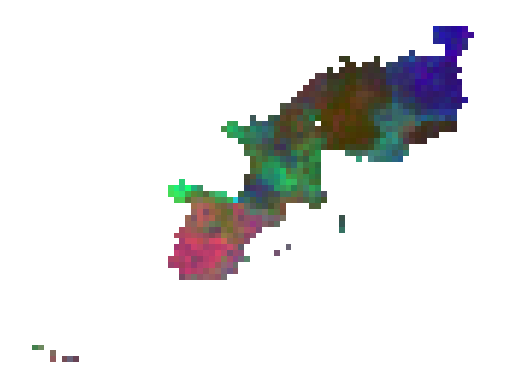

In [35]:
grid_data.plot(color=color)
plt.axis('off')

In [39]:
country_on_grid = grid_data.set_geometry(grid_data.centroid).sjoin(nuts_l1[['geometry', 'NUTS_ID', 'CNTR_CODE', 'NUTS_NAME']], how='left')

In [41]:
pcas = pd.concat([country_on_grid[['geometry', 'NUTS_ID', 'CNTR_CODE', 'NUTS_NAME']], pd.DataFrame(comps)], axis=1)

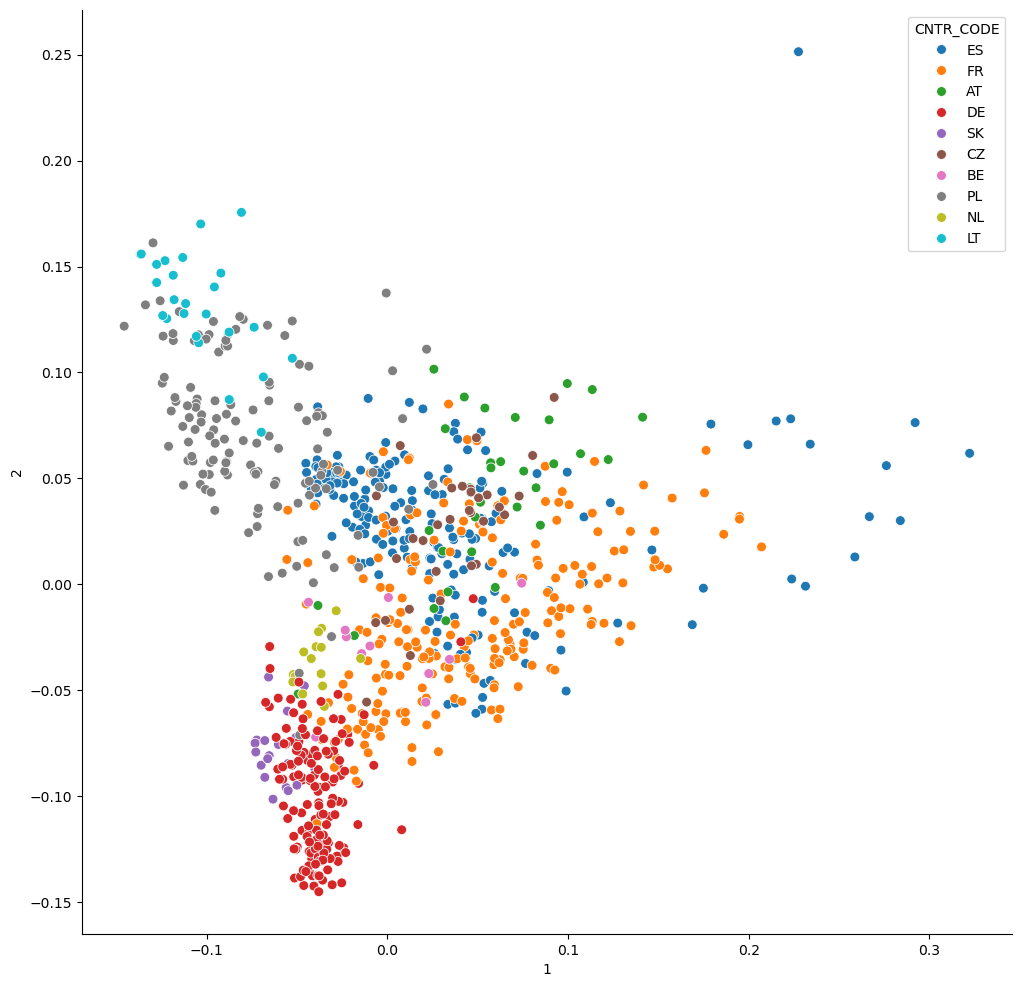

In [44]:
f, ax = plt.subplots(figsize=(12, 12))

sns.scatterplot(x=1, y=2, hue='CNTR_CODE', s=50, data=pcas, ax=ax)
sns.despine()

## UMAP

In [213]:
umap = UMAP(random_state=42, n_jobs=1)
embeddings = umap.fit_transform(grid_data.iloc[:, 2:].values)

In [214]:
umap_embs = pd.concat([country_on_grid[['geometry', 'NUTS_ID', 'CNTR_CODE', 'NUTS_NAME']], pd.DataFrame(embeddings)], axis=1)

In [215]:
cmap = ["#4069BC","#7CBAE4","#E69C63","#ECBF43","#eec1d5","#1F943E", "#b2cd32","#E0665F", "#7A58C2", "#777777"]

Default plot

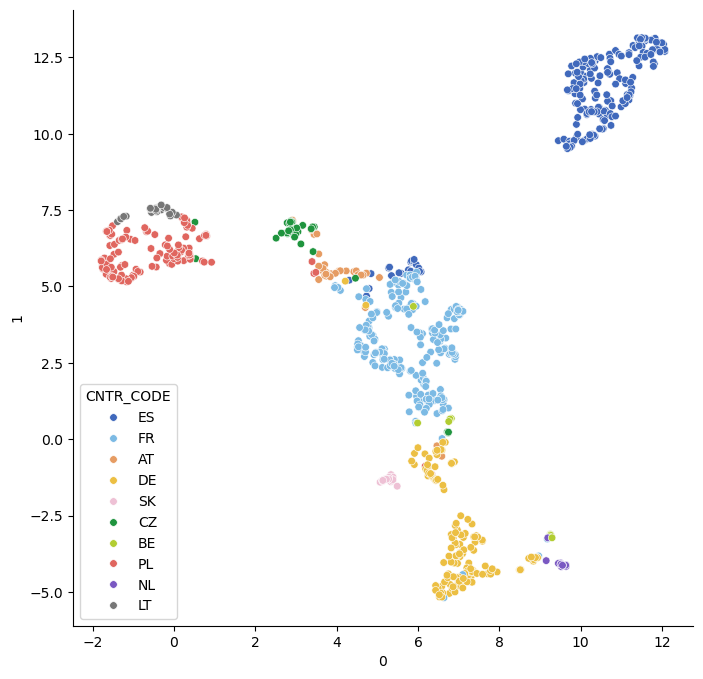

In [216]:
f, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(x=0, y=1, hue='CNTR_CODE', s=30, data=umap_embs, ax=ax, palette=cmap)
sns.despine()

Subplot with a map

In [217]:
umap_embs = umap_embs.set_geometry(umap_embs.centroid.buffer(grid_size / 2))

In [218]:
mapping = dict(zip(umap_embs.CNTR_CODE.unique(), ['#ffffff'] + cmap))

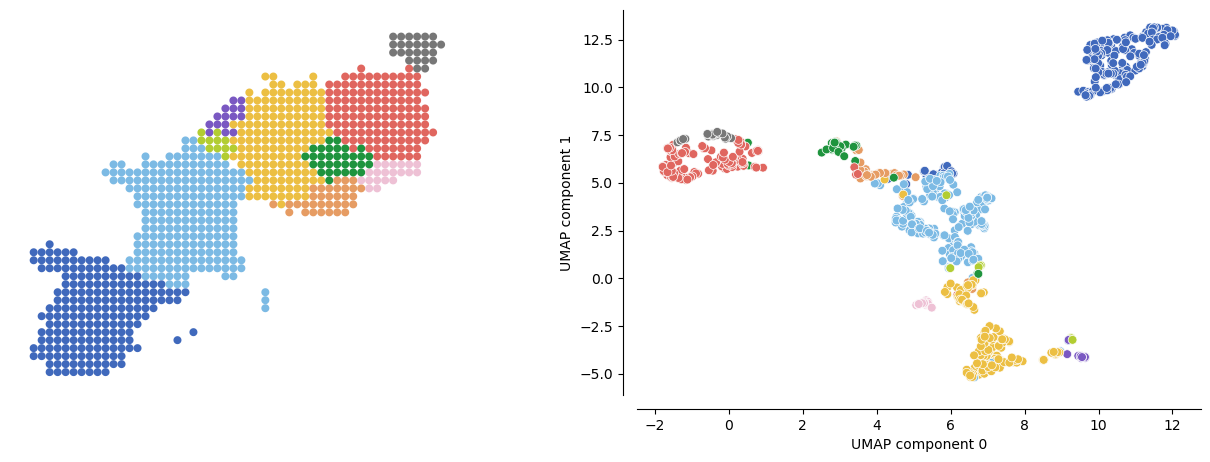

In [193]:
f, axs = plt.subplots(1, 2, figsize=(16, 5))

# scatter
sns.scatterplot(x=0, y=1, hue='CNTR_CODE', s=40, data=umap_embs, ax=axs[1], palette=cmap, legend=False)
sns.despine(offset=10)

# map
umap_embs.plot(ax=axs[0], color=umap_embs.CNTR_CODE.map(mapping))
axs[0].set_xlim(2650000)
axs[0].set_ylim(1500000)
axs[0].set_axis_off()

axs[1].set_xlabel('UMAP component 0')
axs[1].set_ylabel('UMAP component 1')
plt.savefig("../figures/umap.png", dpi=300, bbox_inches='tight')

In [118]:
de = umap_embs[umap_embs.CNTR_CODE == 'DE']
de_above = de[de[1] > -2]

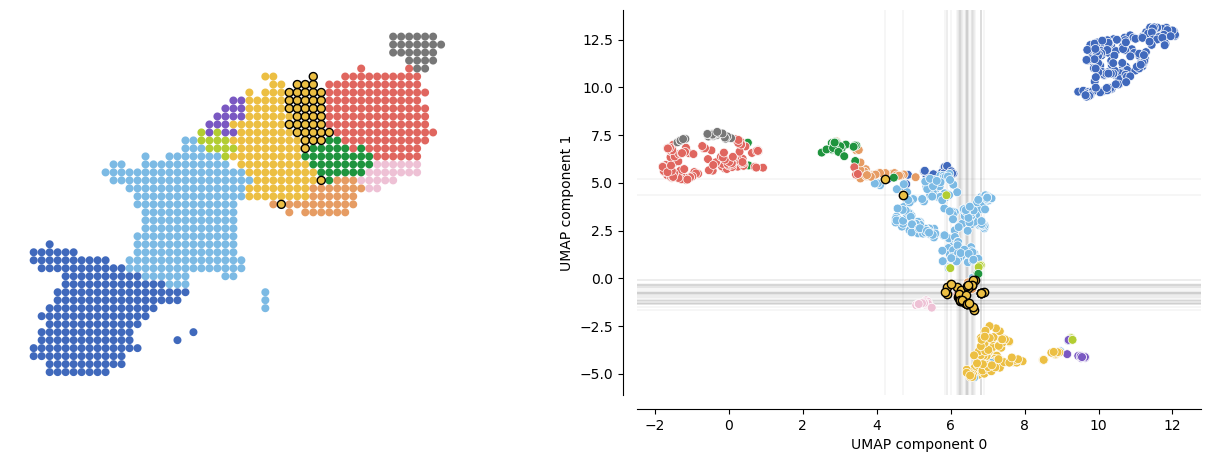

In [194]:
f, axs = plt.subplots(1, 2, figsize=(16, 5))

# scatter
sns.scatterplot(x=0, y=1, hue='CNTR_CODE', s=40, data=umap_embs, ax=axs[1], palette=cmap, legend=False)
sns.despine(offset=10)

# map
umap_embs.plot(ax=axs[0], color=umap_embs.CNTR_CODE.map(mapping))
axs[0].set_xlim(2650000)
axs[0].set_ylim(1500000)
axs[0].set_axis_off()

axs[1].set_xlabel('UMAP component 0')
axs[1].set_ylabel('UMAP component 1')

de_above.plot(ax=axs[0], facecolor='none', edgecolor='k')
axs[1].scatter(x=de_above[0], y=de_above[1], facecolor=mapping['DE'], edgecolor='k')

for x, y in zip(de_above[0], de_above[1]):
    axs[1].axvline(x, color='grey', linewidth=.1, zorder=-1)
    axs[1].axhline(y, color='grey', linewidth=.1, zorder=-1)
plt.savefig("../figures/umap_eastern_germany.png", dpi=300, bbox_inches='tight')

In [126]:
cz = umap_embs[umap_embs.CNTR_CODE == 'CZ']
cz_left = cz[cz[0] < 2]

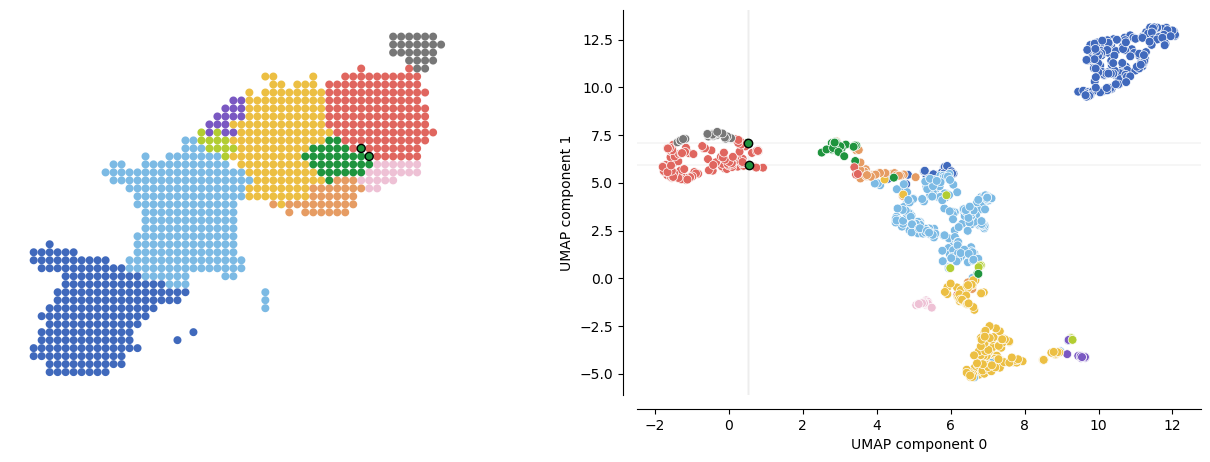

In [200]:
f, axs = plt.subplots(1, 2, figsize=(16, 5))

# scatter
sns.scatterplot(x=0, y=1, hue='CNTR_CODE', s=40, data=umap_embs, ax=axs[1], palette=cmap, legend=False)
sns.despine(offset=10)

# map
umap_embs.plot(ax=axs[0], color=umap_embs.CNTR_CODE.map(mapping))
axs[0].set_xlim(2650000)
axs[0].set_ylim(1500000)
axs[0].set_axis_off()

axs[1].set_xlabel('UMAP component 0')
axs[1].set_ylabel('UMAP component 1')

cz_left.plot(ax=axs[0], facecolor='none', edgecolor='k')
axs[1].scatter(x=cz_left[0], y=cz_left[1], facecolor=mapping['CZ'], edgecolor='k')

for x, y in zip(cz_left[0], cz_left[1]):
    axs[1].axvline(x, color='grey', linewidth=.1, zorder=-1)
    axs[1].axhline(y, color='grey', linewidth=.1, zorder=-1)
plt.savefig("../figures/umap_cz-pl.png", dpi=300, bbox_inches='tight')

In [161]:
pl = umap_embs[umap_embs.CNTR_CODE == 'PL']
pl_right = pl[pl[0] > 2]
pl_left = pl[pl[0] < -.8]

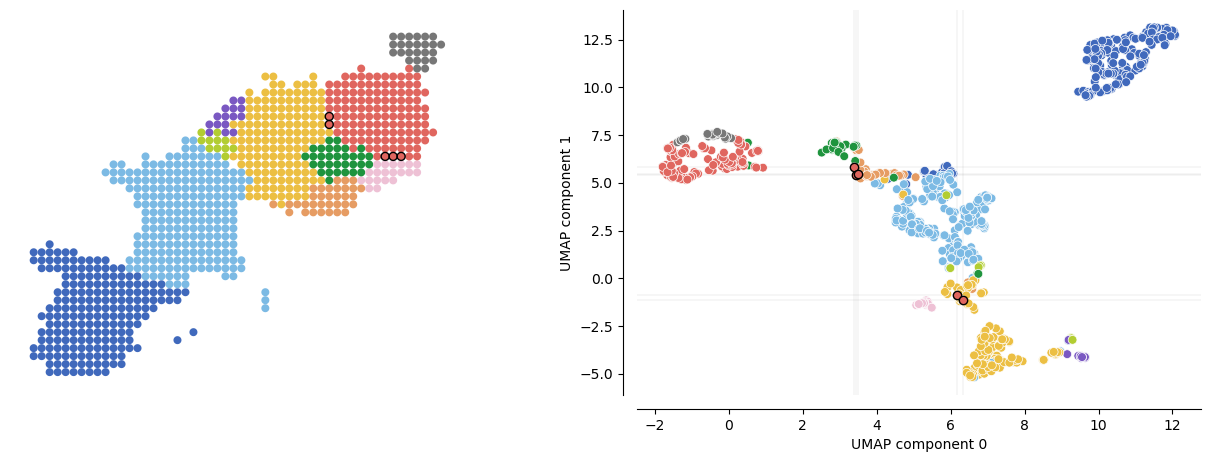

In [199]:
f, axs = plt.subplots(1, 2, figsize=(16, 5))

# scatter
sns.scatterplot(x=0, y=1, hue='CNTR_CODE', s=40, data=umap_embs, ax=axs[1], palette=cmap, legend=False)
sns.despine(offset=10)

# map
umap_embs.plot(ax=axs[0], color=umap_embs.CNTR_CODE.map(mapping))
axs[0].set_xlim(2650000)
axs[0].set_ylim(1500000)
axs[0].set_axis_off()

axs[1].set_xlabel('UMAP component 0')
axs[1].set_ylabel('UMAP component 1')

pl_right.plot(ax=axs[0], facecolor='none', edgecolor='k')
axs[1].scatter(x=pl_right[0], y=pl_right[1], facecolor=mapping['PL'], edgecolor='k')

for x, y in zip(pl_right[0], pl_right[1]):
    axs[1].axvline(x, color='grey', linewidth=.1, zorder=-1)
    axs[1].axhline(y, color='grey', linewidth=.1, zorder=-1)
plt.savefig("../figures/umap_pl_outliers.png", dpi=300, bbox_inches='tight')

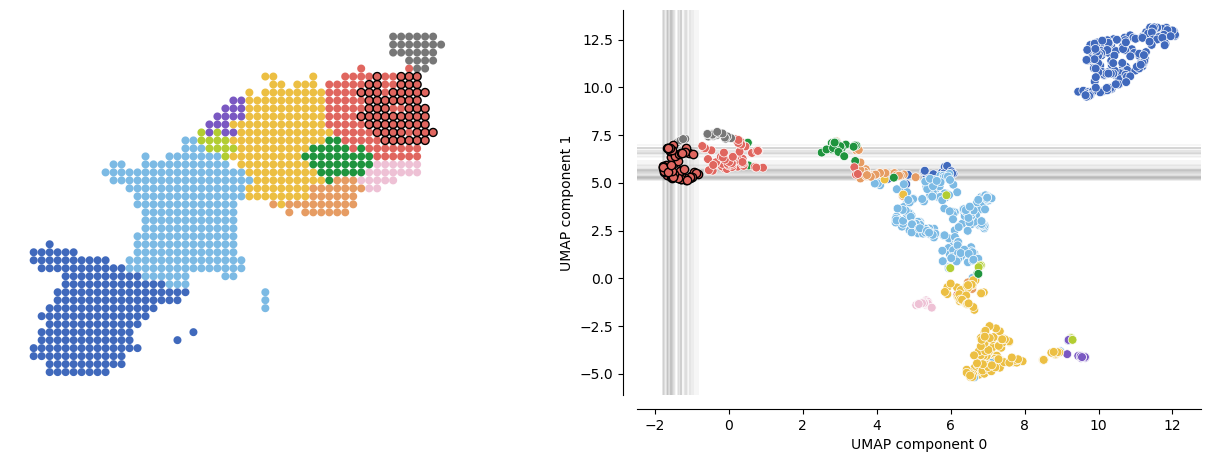

In [198]:
f, axs = plt.subplots(1, 2, figsize=(16, 5))

# scatter
sns.scatterplot(x=0, y=1, hue='CNTR_CODE', s=40, data=umap_embs, ax=axs[1], palette=cmap, legend=False)
sns.despine(offset=10)

# map
umap_embs.plot(ax=axs[0], color=umap_embs.CNTR_CODE.map(mapping))
axs[0].set_xlim(2650000)
axs[0].set_ylim(1500000)
axs[0].set_axis_off()

axs[1].set_xlabel('UMAP component 0')
axs[1].set_ylabel('UMAP component 1')

pl_left.plot(ax=axs[0], facecolor='none', edgecolor='k')
axs[1].scatter(x=pl_left[0], y=pl_left[1], facecolor=mapping['PL'], edgecolor='k')

for x, y in zip(pl_left[0], pl_left[1]):
    axs[1].axvline(x, color='grey', linewidth=.1, zorder=-1)
    axs[1].axhline(y, color='grey', linewidth=.1, zorder=-1)
plt.savefig("../figures/umap_eastern-poland.png", dpi=300, bbox_inches='tight')

In [134]:
be = umap_embs[umap_embs.CNTR_CODE == 'BE']

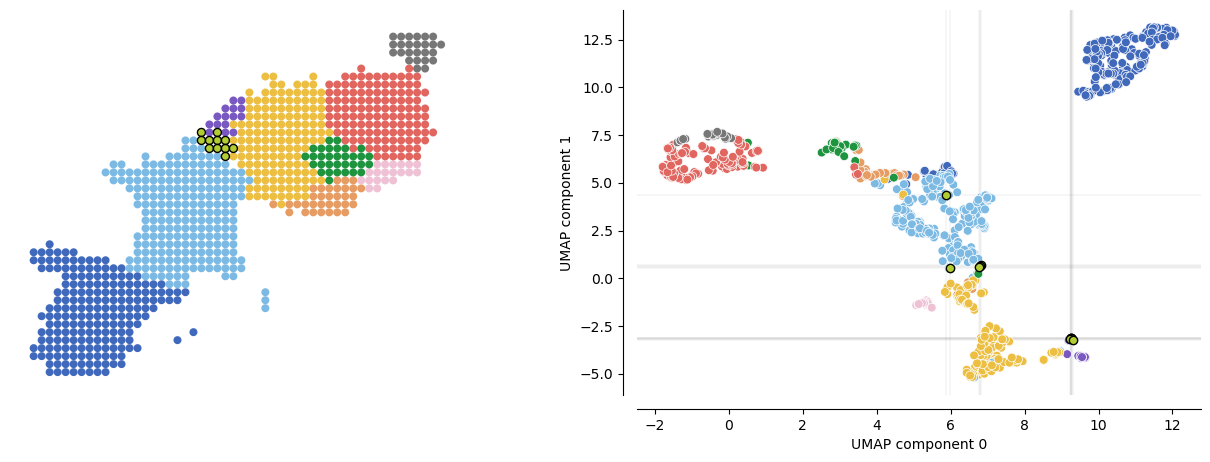

In [201]:
f, axs = plt.subplots(1, 2, figsize=(16, 5))

# scatter
sns.scatterplot(x=0, y=1, hue='CNTR_CODE', s=40, data=umap_embs, ax=axs[1], palette=cmap, legend=False)
sns.despine(offset=10)

# map
umap_embs.plot(ax=axs[0], color=umap_embs.CNTR_CODE.map(mapping))
axs[0].set_xlim(2650000)
axs[0].set_ylim(1500000)
axs[0].set_axis_off()

axs[1].set_xlabel('UMAP component 0')
axs[1].set_ylabel('UMAP component 1')

be.plot(ax=axs[0], facecolor='none', edgecolor='k')
axs[1].scatter(x=be[0], y=be[1], facecolor=mapping['BE'], edgecolor='k')

for x, y in zip(be[0], be[1]):
    axs[1].axvline(x, color='grey', linewidth=.1, zorder=-1)
    axs[1].axhline(y, color='grey', linewidth=.1, zorder=-1)
plt.savefig("../figures/umap_be.png", dpi=300, bbox_inches='tight')

In [137]:
be_top = be[be[1] > 2.5]
be_mid = be[(be[1] < 2.5) & (be[1] > -1)]
be_bot = be[be[1] < -1]

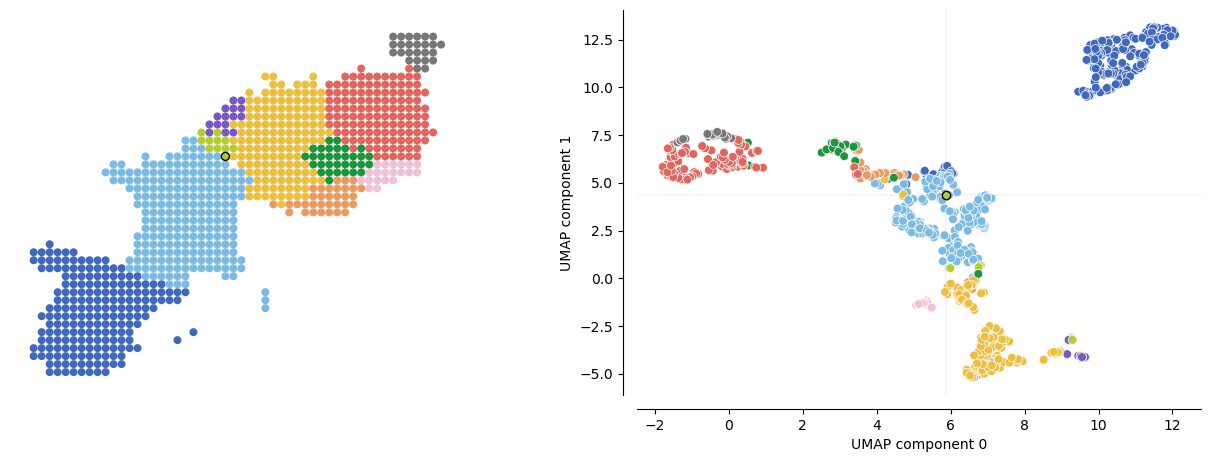

In [202]:
f, axs = plt.subplots(1, 2, figsize=(16, 5))

# scatter
sns.scatterplot(x=0, y=1, hue='CNTR_CODE', s=40, data=umap_embs, ax=axs[1], palette=cmap, legend=False)
sns.despine(offset=10)

# map
umap_embs.plot(ax=axs[0], color=umap_embs.CNTR_CODE.map(mapping))
axs[0].set_xlim(2650000)
axs[0].set_ylim(1500000)
axs[0].set_axis_off()

axs[1].set_xlabel('UMAP component 0')
axs[1].set_ylabel('UMAP component 1')

be_top.plot(ax=axs[0], facecolor='none', edgecolor='k')
axs[1].scatter(x=be_top[0], y=be_top[1], facecolor=mapping['BE'], edgecolor='k')

for x, y in zip(be_top[0], be_top[1]):
    axs[1].axvline(x, color='grey', linewidth=.1, zorder=-1)
    axs[1].axhline(y, color='grey', linewidth=.1, zorder=-1)
plt.savefig("../figures/umap_top.png", dpi=300, bbox_inches='tight')

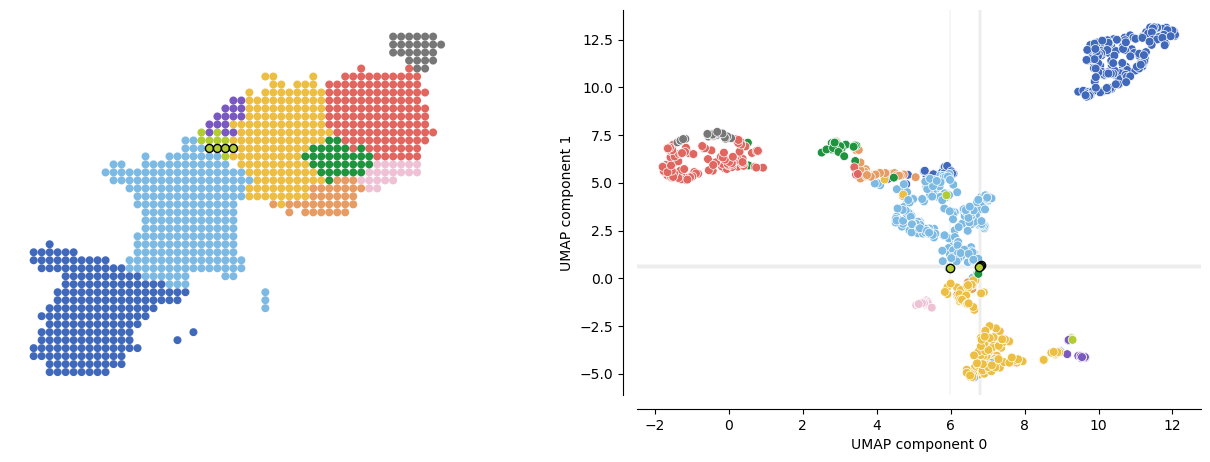

In [203]:
f, axs = plt.subplots(1, 2, figsize=(16, 5))

# scatter
sns.scatterplot(x=0, y=1, hue='CNTR_CODE', s=40, data=umap_embs, ax=axs[1], palette=cmap, legend=False)
sns.despine(offset=10)

# map
umap_embs.plot(ax=axs[0], color=umap_embs.CNTR_CODE.map(mapping))
axs[0].set_xlim(2650000)
axs[0].set_ylim(1500000)
axs[0].set_axis_off()

axs[1].set_xlabel('UMAP component 0')
axs[1].set_ylabel('UMAP component 1')

be_mid.plot(ax=axs[0], facecolor='none', edgecolor='k')
axs[1].scatter(x=be_mid[0], y=be_mid[1], facecolor=mapping['BE'], edgecolor='k')

for x, y in zip(be_mid[0], be_mid[1]):
    axs[1].axvline(x, color='grey', linewidth=.1, zorder=-1)
    axs[1].axhline(y, color='grey', linewidth=.1, zorder=-1)
plt.savefig("../figures/umap_be_mid.png", dpi=300, bbox_inches='tight')

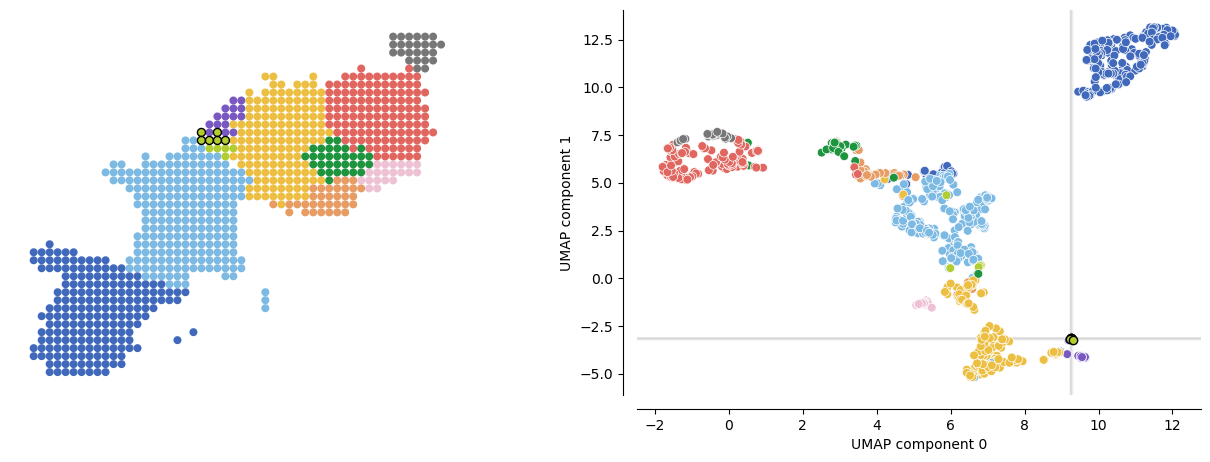

In [204]:
f, axs = plt.subplots(1, 2, figsize=(16, 5))

# scatter
sns.scatterplot(x=0, y=1, hue='CNTR_CODE', s=40, data=umap_embs, ax=axs[1], palette=cmap, legend=False)
sns.despine(offset=10)

# map
umap_embs.plot(ax=axs[0], color=umap_embs.CNTR_CODE.map(mapping))
axs[0].set_xlim(2650000)
axs[0].set_ylim(1500000)
axs[0].set_axis_off()

axs[1].set_xlabel('UMAP component 0')
axs[1].set_ylabel('UMAP component 1')

be_bot.plot(ax=axs[0], facecolor='none', edgecolor='k')
axs[1].scatter(x=be_bot[0], y=be_bot[1], facecolor=mapping['BE'], edgecolor='k')

for x, y in zip(be_bot[0], be_bot[1]):
    axs[1].axvline(x, color='grey', linewidth=.1, zorder=-1)
    axs[1].axhline(y, color='grey', linewidth=.1, zorder=-1)
plt.savefig("../figures/umap_be_nl.png", dpi=300, bbox_inches='tight')

In [155]:
es = umap_embs[umap_embs.CNTR_CODE == 'ES']
es_left = es[es[0] < 8]

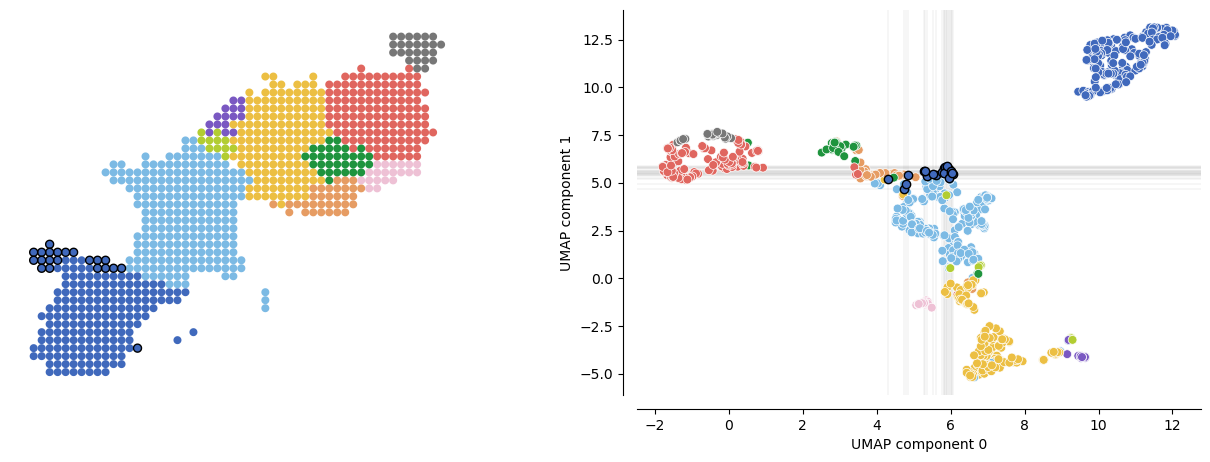

In [205]:
f, axs = plt.subplots(1, 2, figsize=(16, 5))

# scatter
sns.scatterplot(x=0, y=1, hue='CNTR_CODE', s=40, data=umap_embs, ax=axs[1], palette=cmap, legend=False)
sns.despine(offset=10)

# map
umap_embs.plot(ax=axs[0], color=umap_embs.CNTR_CODE.map(mapping))
axs[0].set_xlim(2650000)
axs[0].set_ylim(1500000)
axs[0].set_axis_off()

axs[1].set_xlabel('UMAP component 0')
axs[1].set_ylabel('UMAP component 1')

es_left.plot(ax=axs[0], facecolor='none', edgecolor='k')
axs[1].scatter(x=es_left[0], y=es_left[1], facecolor=mapping['ES'], edgecolor='k')

for x, y in zip(es_left[0], es_left[1]):
    axs[1].axvline(x, color='grey', linewidth=.1, zorder=-1)
    axs[1].axhline(y, color='grey', linewidth=.1, zorder=-1)
plt.savefig("../figures/umap_galicia.png", dpi=300, bbox_inches='tight')

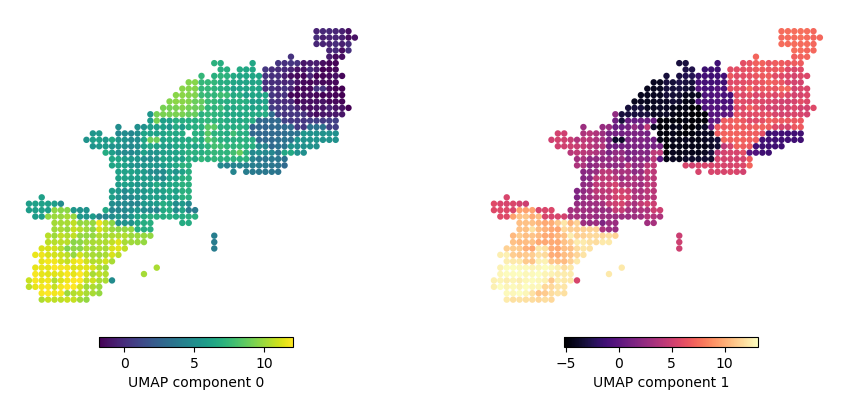

In [241]:
f, axs = plt.subplots(1, 2, figsize=(11, 5))

umap_embs.plot(0, ax=axs[0], legend=True, legend_kwds={"orientation": "horizontal", 'shrink': 0.5, 'pad': .05, 'label': 'UMAP component 0'})
axs[0].set_xlim(2650000)
axs[0].set_ylim(1500000)
axs[0].set_axis_off()


umap_embs.plot(1, ax=axs[1], cmap='magma', legend=True, legend_kwds={"orientation": "horizontal", 'shrink': 0.5, 'pad': .05, 'label': 'UMAP component 1'})
axs[1].set_xlim(2650000)
axs[1].set_ylim(1500000)
axs[1].set_axis_off()

plt.savefig("../figures/umap_components.png", dpi=300, bbox_inches='tight')

In [244]:
grid_data = grid_data.set_geometry(grid_data.centroid.buffer(grid_size / 2))

In [263]:
grid_data.iloc[:, 2:].max().sort_values().tail(6)

86    0.266459
23    0.267992
70    0.290637
36    0.344140
39    0.379096
35    1.000000
dtype: float64

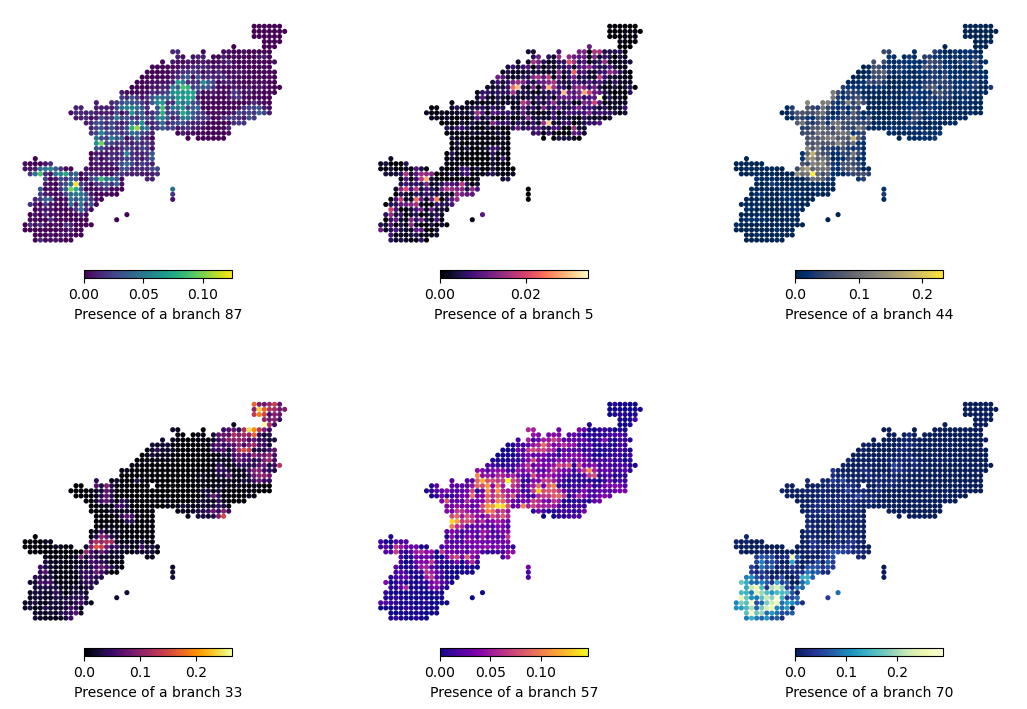

In [268]:
f, axs = plt.subplots(2, 3, figsize=(13, 9))

grid_data.plot(87, ax=axs[0, 0], legend=True, legend_kwds={"orientation": "horizontal", 'shrink': 0.5, 'pad': .05, 'label': 'Presence of a branch 87'})

grid_data.plot(5, ax=axs[0, 1], cmap='magma', legend=True, legend_kwds={"orientation": "horizontal", 'shrink': 0.5, 'pad': .05, 'label': 'Presence of a branch 5'})

grid_data.plot(44, ax=axs[0, 2], cmap='cividis', legend=True, legend_kwds={"orientation": "horizontal", 'shrink': 0.5, 'pad': .05, 'label': 'Presence of a branch 44'})

grid_data.plot(33, ax=axs[1, 0], cmap='inferno', legend=True, legend_kwds={"orientation": "horizontal", 'shrink': 0.5, 'pad': .05, 'label': 'Presence of a branch 33'})

grid_data.plot(57, ax=axs[1, 1], cmap='plasma', legend=True, legend_kwds={"orientation": "horizontal", 'shrink': 0.5, 'pad': .05, 'label': 'Presence of a branch 57'})

grid_data.plot(70, ax=axs[1, 2], cmap='YlGnBu_r', legend=True, legend_kwds={"orientation": "horizontal", 'shrink': 0.5, 'pad': .05, 'label': 'Presence of a branch 70'})


for ax in axs.flat:
    ax.set_xlim(2650000)
    ax.set_ylim(1500000)
    ax.set_axis_off()

plt.savefig("../figures/branch_proportions.png", dpi=300, bbox_inches='tight')